-- Deep Learning Technique for Improving the Recognition
of Handwritten Signature

/opt/anaconda3/envs/signature_3-10-14/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/signature_3-10-14/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/hbasriuzun/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


Epoch 1/10
----------
train Loss: 0.3650 Acc: 0.8187
val Loss: 0.1322 Acc: 0.9583
Epoch 2/10
----------
train Loss: 0.2190 Acc: 0.9124
val Loss: 0.1063 Acc: 0.9621
Epoch 3/10
----------
train Loss: 0.1977 Acc: 0.9233
val Loss: 0.0762 Acc: 0.9830
Epoch 4/10
----------
train Loss: 0.1901 Acc: 0.9242
val Loss: 0.0746 Acc: 0.9735
Epoch 5/10
----------
train Loss: 0.1745 Acc: 0.9295
val Loss: 0.0705 Acc: 0.9735
Epoch 6/10
----------
train Loss: 0.2100 Acc: 0.9209
val Loss: 0.0755 Acc: 0.9716
Epoch 7/10
----------
train Loss: 0.1917 Acc: 0.9209
val Loss: 0.0635 Acc: 0.9773
Epoch 8/10
----------
train Loss: 0.1972 Acc: 0.9143
val Loss: 0.0653 Acc: 0.9754
Epoch 9/10
----------
train Loss: 0.1683 Acc: 0.9361
val Loss: 0.0611 Acc: 0.9792
Epoch 10/10
----------
train Loss: 0.1819 Acc: 0.9242
val Loss: 0.0726 Acc: 0.9754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5253019..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88492167..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69654936..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78217316..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6451751..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7307989..2.64].


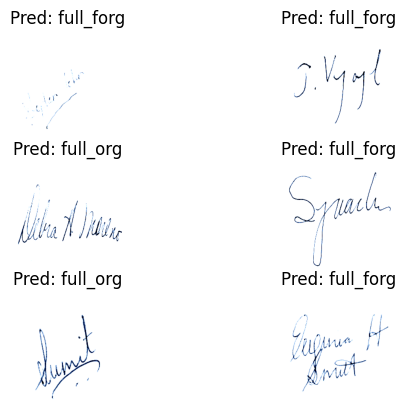

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

# Veri dönüşümleri: Resimleri AlexNet’in beklediği 227x227 boyutuna yeniden boyutlandırır
data_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Veri kümeleri ve DataLoader tanımları
data_dir = '1_veri_setleri/1_Cedar_dataset'
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Veri kümesini eğitim ve doğrulama kümelerine ayırma
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes  # 'full_forg' ve 'full_org' klasör isimleri sınıf isimleri olarak alınır

# AlexNet modelini yükleyip son katmanları özelleştiriyoruz
model = models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Önceki katmanları dondur

# Son sınıflandırma katmanını yeniden tanımla (2 sınıf: authentic ve forgery)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Kayıp fonksiyonu ve optimizasyon algoritması
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Eğitim ve doğrulama fonksiyonu
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Her epoch için eğitim ve doğrulama fazı
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Eğitim moduna geç
            else:
                model.eval()  # Doğrulama moduna geç

            running_loss = 0.0
            running_corrects = 0

            # Verileri teker teker işleyelim
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Kayıpları ve doğruluğu hesapla
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

# Modeli eğit
model = train_model(model, criterion, optimizer, num_epochs=10)

# Eğitimden sonra örnek bir imza resmi ile test yapalım
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0).numpy())

                if images_so_far == num_images:
                    return

# Test sonuçlarını görselleştir
visualize_model(model)
